In [1]:
import pandas as pd
from enum import Enum
import numpy as np
import scipy
from numpy import sqrt, sin, cos, pi
from scipy.integrate import odeint
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


const_density = 997
const_kinematicViscosity = 8.917*10**-7
const_dynamicViscosity = const_kinematicViscosity * const_density

'''
Air:
const_density = 1.184
const_kinematicViscosity = 18.37*10**-6
const_dynamicViscosity = const_kinematicViscosity * const_density
'''


class flow_parameters():
    '''Storing variables'''
    def alternator(self, rpm, torque):
        self.var_omega = (rpm/60)*2*pi
        self.var_torque = torque

    def disc(self, inner_radius, outer_radius, disc_thickness, disc_spacing):
        self.var_innerRadius = inner_radius
        self.var_outerRadius = outer_radius
        self.var_discThickness = disc_thickness
        self.var_discSpacing = disc_spacing

    def inlet(self, Vr, Vtheta):
        self.inletVradial = Vr
        self.inletVtheta = Vtheta  # 0 being parallel to disc

    def derived(self):
        self.nozzleAngle = np.arctan(abs(self.inletVtheta/self.inletVradial))
        
        self.volumeFlowRate = 2*pi*self.var_outerRadius*self.var_discSpacing*abs(self.inletVradial)
        self.massFlowRate = self.volumeFlowRate*const_density

        self.innerOuterRatio = self.var_innerRadius/self.var_outerRadius
        self.phi2 = self.inletVradial / \
            (self.var_omega*self.var_outerRadius)
        self.gamma = self.inletVtheta / \
            (self.var_omega*self.var_outerRadius)

In [2]:
def zProfile(zs, instance):
    '''Velocity profile in z axis'''
    return np.array([6*(zs)*(1-zs)]).transpose()


def velocityRadial3D(rs, zs, instance):
    '''3d plot points for radial velocity'''
    return np.array(instance.inletVradial*(1/rs)*zProfile(zs, instance))


def velocitytangential3D(rs, zs, instance, firstAnswer):
    '''3d plot points for tangential velocity'''
    return np.array(instance.inletVtheta*firstAnswer*zProfile(zs, instance))


def bothODE(Y, R, instance):
    '''Coupled ODE equations'''
    v = const_kinematicViscosity
    phi = instance.phi2
    gamma = instance.gamma
    omegaspace = instance.var_omega*instance.var_discSpacing**2
    Y01 = Y[0]

    first_term1 = -(1/R + 10*(v/omegaspace)*(R/phi))*Y01 - 10/(6*(gamma-1))

    second_term1 = R + 2*(gamma - 1)*Y01 + (6/5)*(Y01**2/R)*(gamma - 1)**2
    second_term2 = (6/5)*(phi**2/R**3)-12*(v / omegaspace)*(phi/R)

    return [first_term1, second_term1+second_term2]

def workDone(instance, rs, firstAnswer):
    '''Calculation of work done'''
    firstAnswer1 = np.flip(firstAnswer)
    rs1 = np.flip(rs)
    
    coef = (12*pi*const_dynamicViscosity*abs(instance.inletVtheta)*instance.var_outerRadius**3)/instance.var_discSpacing
    toBeIntegrated = np.power(rs1,2)*firstAnswer1
    return 2*coef*np.trapz(toBeIntegrated, x = rs1)*instance.var_omega

def efficiency(instance, rs, answer):
    MFR = instance.massFlowRate
    inlet = (np.linalg.norm([instance.inletVradial,instance.inletVtheta]))**2
    VTLast, PLast = abs(answer[-1,0]),abs(answer[-1,1])
    VRLast = instance.inletVradial * (instance.var_outerRadius/instance.var_innerRadius)
    outlet = (np.linalg.norm([VTLast, VRLast]))**2
    energyChange = PLast*const_density*(instance.var_omega*instance.var_outerRadius)**2/const_density + 0.5*(inlet-outlet)
    return workDone(instance, rs, answer[:,0])/energyChange
    

def Report(instance, rs, answer):
    '''Gamma, pressure difference, and power out'''
    print("Gamma is: ", instance.gamma)
    print("Pressure difference: ", (1/100000)*abs(
        answer[:, 1][-1])*const_density*(instance.var_omega**2)*(instance.var_outerRadius**2), "bar")
    print("Power out is: ", workDone(instance, rs, answer[:,0]), "Watt")
    print("Efficiency: ", efficiency(instance, rs, answer)*100, "%")

In [39]:
KJ = flow_parameters()
KJ.alternator(250, 100) #1000 rpm
# inner radius and outer radius can be amended, disc spacing as well
KJ.disc(0.125, 0.25, 0.005, 0.005)
KJ.inlet(-1, 9.82)
KJ.derived()
print("Volume flow rate is: ", KJ.volumeFlowRate, "m3/s")
initialCondition = [1, 0]

zs = np.linspace(0, 1, 25)
rs = np.linspace(1, KJ.innerOuterRatio, 50)
X, Y = np.meshgrid(rs, zs)
answer = odeint(
    bothODE, initialCondition, rs, args=(KJ,))
answer1, answer2 = answer[:, 0], answer[:, 1]
Report(KJ,rs,answer)

#root finding algorithm to find pressre drop based on flow rate

Volume flow rate is:  0.007853981633974483 m3/s
Gamma is:  1.5003854795159157
Pressure difference:  1.3765469292994175 bar
Power out is:  32.331566505097996 Watt
Efficiency:  18.4599204912531 %


In [75]:
#efficiency graph across Nre and V0
testKJ = flow_parameters()
testKJ.alternator(250,100)
testKJ.disc(0.0625,0.125,0.005,0.005)
testKJ.inlet(-0.2,9.82)
testKJ.derived()

rs = np.linspace(1, testKJ.innerOuterRatio, 50)
discSpacingList = np.linspace(0.002,0.01,100)
V0List = (testKJ.var_omega*testKJ.var_outerRadius)*np.linspace(0.5,2,50)

z_eff = np.zeros((len(discSpacingList),len(V0List)))

for i in range(len(discSpacingList)):
    for j in range(len(V0List)):
        testKJ.var_discSpacing = discSpacingList[i]
        testKJ.inletVtheta = V0List[j]
        testKJ.derived()
        ANSWER = odeint(bothODE, [1,0], rs, args=(testKJ,))
        z_eff[i, j] = efficiency(testKJ, rs, ANSWER)

ValueError: Unknown projection 'contour'

<Figure size 432x288 with 0 Axes>

In [2]:
X,Y = np.meshgrid(discSpacingList, np.linspace(0.5,2,50))
#(testKJ.var_omega/const_kinematicViscosity)*np.power(discSpacingList,2)
fig1 = plt.figure()
ax1 = fig1.gca()
ax1.set_xlabel('discSpacing')
ax1.set_ylabel('V0')
surf = ax1.contourf(X, Y, z_eff.transpose(), np.linspace(0,1,20))
plt.show()

NameError: name 'np' is not defined

In [61]:
# Dimensinoless states : Gamma, Phi, Nre
# changable variables: Vtheta, Vr, disc_spacing
# set constant flow rate, Vr is constant
# find for a set of constant omegas
from scipy.optimize import minimize
from scipy.optimize import Bounds

def cost_J(x, frs, instance):
    theta,spacing = x[0],x[1]
    instance.inletVtheta = abs(theta)
    instance.var_discSpacing = abs(spacing)
    instance.derived()
    costAnswer = odeint(
        bothODE, [1,0], frs, args=(instance,))
    return (efficiency(instance, frs, costAnswer) - 1)**2

def optimisedOmega(rs,zs,ws,instance,boundedValues = [[0.1, 3], [0.002, 0.01]]):
    output = []
    for i in ws:
        instance.var_omega = i*2*pi/60
        instance.derived()
        bounds = Bounds([boundedValues[0][0]*instance.var_omega*instance.var_outerRadius,\
                         boundedValues[1][0]],
                        [boundedValues[0][1]*instance.var_omega*instance.var_outerRadius,\
                         boundedValues[1][1]]) # self justified
        x0 = np.array([np.sum(boundedValues[0])/1.5,np.sum(boundedValues[1])/1.5])
        res = minimize(cost_J, x0, method='SLSQP', args = (rs,instance),
               options={'disp': False},bounds=bounds)
        output.append(res)
    return np.array(output)

In [71]:
optKJ = flow_parameters()
optKJ.alternator(250, 100)
optKJ.disc(0.0625, 0.125, 0.005, 0.005)
optKJ.inlet(-0.2, 5) #volume flow rate range
optKJ.derived()
print(f"Volume Flow Rate: {optKJ.volumeFlowRate} m3/s")

VRadialInlet = -np.linspace(0.05, 0.3, 75)
rpmList = np.arange(500,5000,10)
zs = np.linspace(0, 1, 25)
rs = np.linspace(1, optKJ.innerOuterRatio, 50)

Volume Flow Rate: 0.0007853981633974484 m3/s


In [72]:
Efficiencies = optimisedOmega(rs,zs,rpmList,optKJ)
for i in range(len(Efficiencies)):
    rpm = rpmList[i]
    omega = rpm*2*pi/60
    vtangential, spacingdisc = Efficiencies[i].x
    gamma = vtangential/(omega*optKJ.var_outerRadius)
    Nre = omega*spacingdisc**2/const_kinematicViscosity
    print(f"rpm: {rpm}\nVtheta: {vtangential} ms-1, Gamma: {gamma}\nDisc Spacing: {spacingdisc} m, Nre: {Nre}\nEfficiency = {1-sqrt(Efficiencies[i].fun)}\n")

rpm: 500
Vtheta: 1.1422258444256255 ms-1, Gamma: 0.17451925369694643
Disc Spacing: 0.0028460971363676126 m, Nre: 475.6410096562109
Efficiency = 0.1310812528382036

rpm: 510
Vtheta: 1.1665824718558904 ms-1, Gamma: 0.17474575710138995
Disc Spacing: 0.002844302698776291 m, Nre: 484.54225281423584
Efficiency = 0.13109647085706366

rpm: 520
Vtheta: 1.190167252172635 ms-1, Gamma: 0.1748501550363445
Disc Spacing: 0.0028428377114508435 m, Nre: 493.5342884350613
Efficiency = 0.13111097152475049

rpm: 530
Vtheta: 1.2112565794367522 ms-1, Gamma: 0.1745909180105118
Disc Spacing: 0.0028440854378488723 m, Nre: 503.46698672382394
Efficiency = 0.13112512251269137

rpm: 540
Vtheta: 1.235028438112559 ms-1, Gamma: 0.17472078291971263
Disc Spacing: 0.0028428803029788598 m, Nre: 512.5317336556467
Efficiency = 0.13113830141706972

rpm: 550
Vtheta: 1.258736363100142 ms-1, Gamma: 0.17483704515220574
Disc Spacing: 0.002840312664313053 m, Nre: 521.0805240964255
Efficiency = 0.13115076551908567

rpm: 560
Vtheta:

Text(0, 0.5, 'Best Efficiency')

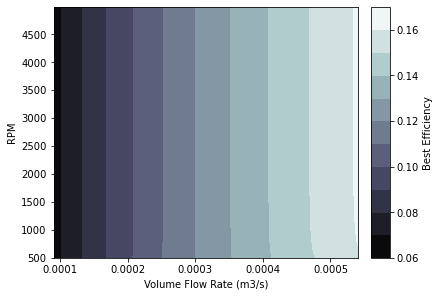

In [67]:
bestEff = np.zeros((len(VRadialInlet),len(rpmList)))
for i in range(len(VRadialInlet)):
    optKJ.inletVradial = VRadialInlet[i]
    Efficiencies = optimisedOmega(rs,zs,rpmList,optKJ)
    for j in range(len(Efficiencies)):
        bestEff[i,j] = 1-sqrt(Efficiencies[j].fun)
X, Y = np.meshgrid(2*pi*optKJ.var_outerRadius*optKJ.var_discSpacing*abs(VRadialInlet),rpmList)
fig1, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contourf(X, Y, bestEff.transpose(), 10, cmap=plt.cm.bone, origin='lower')
ax2.set_xlabel('Volume Flow Rate (m3/s)')
ax2.set_ylabel('RPM')
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Best Efficiency')